**Итог:**
1. Построена одна небольашя сеть вручную.
2. Использована предобученная сеть ResNet50
3. Использована предобученная сеть ResNet50 для данных с аугментацией (с помощью бибилиотеки Albumentations).

**Выводы:**
1. Нейросети - мощная вещь. Даже примитивная сетка (пробовала оставить 1 дропаут, 1 конволюционный слой с нормализацией, 2 линейных слоя) даёт показатели в районе 50% Accuracy на таких сложных данных.
2. Предобученная огромная модель сразу сильно увеличивает Accuracy до 70-80%
3. Использование аугментации (неслабой) немного снижает значение Accuracy. Но при этом Accuracy для тестовых данных стабильно и значительно выше, чем для тренировочных, что говорит о качественном обучении.
Т.к. данные и так сложноватые, а при аугментации усложняются ещё больше, становятся разнообразнее, думаю, сетке просто необходимо чуть больше времени (эпох) для обучения. Переобучить такую сеть сложно, поэтому в итоге результат может получиться отличным.

*Сравнительный график представлен в конце ноутбука*


In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm
from torchsummary import summary
from torchvision import models

from sklearn.model_selection import train_test_split

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
dataset = datasets.CIFAR10(root='data/', train=True, download=True)

train, test = train_test_split(dataset, test_size=0.1, random_state=26, shuffle=True)

Files already downloaded and verified


In [4]:
class MyOwnCifar(torch.utils.data.Dataset):

    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

class MyOwnCifarAug(torch.utils.data.Dataset):

    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(image=np.array(img))["image"]
        return img, self._base_dataset[idx][1]


In [5]:
manual_train_trans = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor()])


manual_train_dataset = MyOwnCifar(train, manual_train_trans)
manual_test_dataset = MyOwnCifar(test, transforms.ToTensor())



manual_train_loader = torch.utils.data.DataLoader(manual_train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=1)
manual_test_loader = torch.utils.data.DataLoader(manual_test_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [6]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.15)
        self.dp_four = nn.Dropout(0.25)

        self.bn_one = torch.nn.BatchNorm2d(3)
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30)
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        self.fc2 = torch.nn.Linear(200, 60)
        self.out = torch.nn.Linear(60, 10)


    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)

net = Net().to(device)
print(net)

Net(
  (dp_three): Dropout(p=0.15, inplace=False)
  (dp_four): Dropout(p=0.25, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [7]:
summary(net.to(device), input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 200]          96,200
          Dropout-10                  [-1, 200]               0
           Linear-11                   [-1, 60]          12,060
           Linear-12                   [-1, 10]             610
Total params: 191,316
Trainable params: 191,316
Non-trainable params: 0
-------------------------------

In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

manual_acc = []
for epoch in tqdm(range(10)):
    net.train()
    right, num = 0, 0
    for i, data in enumerate(manual_train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        right += (labels == torch.max(outputs, 1)[1]).sum()
        num += len(labels)

    net.eval()
    loss_accumed, test_right, test_num = 0, 0, 0
    for X, y in manual_test_loader:
        output = net(X.to(device))
        loss = criterion(output, y.to(device))
        loss_accumed += loss
        test_num += len(y)
        test_right += (y.to(device) == torch.max(output, 1)[1]).sum()

    train_acc = right/num
    test_acc = test_right/test_num
    manual_acc.append(test_acc)
    print(f"Epoch {epoch+1}; test_loss {loss_accumed:.3f}; test_acc {test_acc:.3f}; train_acc {train_acc:.3f}")

print('Training is finished!')

 10%|█         | 1/10 [00:14<02:06, 14.01s/it]

Epoch 1; test_loss 71.472; test_acc 0.364; train_acc 0.285


 20%|██        | 2/10 [00:27<01:49, 13.74s/it]

Epoch 2; test_loss 64.687; test_acc 0.426; train_acc 0.387


 30%|███       | 3/10 [00:42<01:40, 14.31s/it]

Epoch 3; test_loss 56.568; test_acc 0.497; train_acc 0.431


 40%|████      | 4/10 [00:56<01:25, 14.30s/it]

Epoch 4; test_loss 59.609; test_acc 0.478; train_acc 0.472


 50%|█████     | 5/10 [01:10<01:11, 14.21s/it]

Epoch 5; test_loss 57.040; test_acc 0.524; train_acc 0.490


 60%|██████    | 6/10 [01:24<00:56, 14.05s/it]

Epoch 6; test_loss 54.318; test_acc 0.526; train_acc 0.506


 70%|███████   | 7/10 [01:38<00:42, 14.13s/it]

Epoch 7; test_loss 50.789; test_acc 0.566; train_acc 0.521


 80%|████████  | 8/10 [01:53<00:28, 14.13s/it]

Epoch 8; test_loss 50.351; test_acc 0.572; train_acc 0.530


 90%|█████████ | 9/10 [02:06<00:14, 14.01s/it]

Epoch 9; test_loss 52.821; test_acc 0.558; train_acc 0.531


100%|██████████| 10/10 [02:20<00:00, 14.07s/it]

Epoch 10; test_loss 53.144; test_acc 0.556; train_acc 0.544
Training is finished!


In [9]:
resnet50 = models.resnet50(pretrained=True)

# Необходимые трансформации
resnet_train_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

resnet_test_transform = transforms.Compose([transforms.Resize(224),
                                            transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

resnet_train_dataset = MyOwnCifar(train, resnet_train_transform)
resnet_test_dataset = MyOwnCifar(test, resnet_test_transform)


resnet_train_loader = torch.utils.data.DataLoader(resnet_train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=1)
resnet_test_loader = torch.utils.data.DataLoader(resnet_test_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

for param in resnet50.parameters():
  param.requires_grad = False

#print(resnet50)

in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features=in_features, out_features=10)

params_for_optim = []
for name, param in resnet50.named_parameters():
  if param.requires_grad == True:
    params_for_optim.append(param)

#summary(resnet50.to(device), input_size=(3,32,32))
resnet50 = resnet50.to(device)
optimizer = torch.optim.Adam(params_for_optim, lr=0.01)
criterion = nn.CrossEntropyLoss()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
resnet_acc = []
for epoch in tqdm(range(10)):
    resnet50.train()
    right, num = 0, 0
    for i, data in enumerate(resnet_train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        right += (labels == torch.max(outputs, 1)[1]).sum()
        num += len(labels)

    resnet50.eval()
    loss_accumed, test_right, test_num = 0, 0, 0
    for X, y in resnet_test_loader:
        output = resnet50(X.to(device))
        loss = criterion(output, y.to(device))
        loss_accumed += loss
        test_num += len(y)
        test_right += (y.to(device) == torch.max(output, 1)[1]).sum()

    train_acc = right/num
    test_acc = test_right/test_num
    resnet_acc.append(test_acc)
    print(f"Epoch {epoch+1}; test_loss {loss_accumed:.3f}; test_acc {test_acc:.3f}; train_acc {train_acc:.3f}")

print('Training is finished!')

 10%|█         | 1/10 [02:36<23:31, 156.79s/it]

Epoch 1; test_loss 26.493; test_acc 0.774; train_acc 0.674


 20%|██        | 2/10 [05:13<20:52, 156.54s/it]

Epoch 2; test_loss 26.317; test_acc 0.785; train_acc 0.738


 30%|███       | 3/10 [07:49<18:15, 156.45s/it]

Epoch 3; test_loss 38.325; test_acc 0.744; train_acc 0.737


 40%|████      | 4/10 [10:25<15:38, 156.46s/it]

Epoch 4; test_loss 27.256; test_acc 0.785; train_acc 0.745


 50%|█████     | 5/10 [13:02<13:02, 156.40s/it]

Epoch 5; test_loss 29.162; test_acc 0.788; train_acc 0.753


 60%|██████    | 6/10 [15:38<10:25, 156.32s/it]

Epoch 6; test_loss 27.927; test_acc 0.790; train_acc 0.759


 70%|███████   | 7/10 [18:14<07:48, 156.31s/it]

Epoch 7; test_loss 27.779; test_acc 0.801; train_acc 0.759


 80%|████████  | 8/10 [20:50<05:12, 156.28s/it]

Epoch 8; test_loss 27.519; test_acc 0.814; train_acc 0.759


 90%|█████████ | 9/10 [23:28<02:36, 156.58s/it]

Epoch 9; test_loss 29.594; test_acc 0.791; train_acc 0.771


100%|██████████| 10/10 [26:03<00:00, 156.40s/it]

Epoch 10; test_loss 23.891; test_acc 0.819; train_acc 0.772
Training is finished!


In [11]:
import albumentations as alb
from albumentations.pytorch import ToTensorV2
import numpy as np

In [12]:
alb_train_transform = alb.Compose([
    alb.Resize(height=256, width=256),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RGBShift(r_shift_limit=(-5,5),g_shift_limit=(-5,5),b_shift_limit=(-5,5)),
    alb.GaussNoise(p=0.2),
    alb.RandomCrop(height=224, width=224),
    alb.Rotate(limit=60, p=0.3),
    alb.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()]
)

alb_test_transform = alb.Compose(
    [alb.Resize(height=256, width=256),
    alb.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()]
)


In [13]:
resnet50aug = models.resnet50(pretrained=True)



aug_train_dataset = MyOwnCifarAug(train, alb_train_transform)
aug_test_dataset = MyOwnCifarAug(test, alb_test_transform)


aug_train_loader = torch.utils.data.DataLoader(aug_train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=1)
aug_test_loader = torch.utils.data.DataLoader(aug_test_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

for param in resnet50aug.parameters():
  param.requires_grad = False

in_features = resnet50aug.fc.in_features
resnet50aug.fc = nn.Linear(in_features=in_features, out_features=10)

params_for_optim = []
for name, param in resnet50aug.named_parameters():
  if param.requires_grad == True:
    params_for_optim.append(param)

resnet50aug = resnet50aug.to(device)
optimizer = torch.optim.Adam(params_for_optim, lr=0.01)
criterion = nn.CrossEntropyLoss().to(device)

In [14]:
for param in resnet50aug.parameters():
  if not param.data.is_cuda:
    print(param.data)

In [15]:
resnet_aug_acc = []
for epoch in tqdm(range(10)):
    resnet50aug.train()
    right, num = 0, 0
    for i, data in enumerate(aug_train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = resnet50aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        right += (labels == torch.max(outputs, 1)[1]).sum()
        num += len(labels)

    resnet50aug.eval()
    loss_accumed, test_right, test_num = 0, 0, 0
    for i, data in enumerate(aug_test_loader, 0):
        X, y = data[0].to(device), data[1].to(device)
        # X = torch.FloatTensor(X)
        # y = torch.FloatTensor(y)
        output = resnet50aug(X)
        loss = criterion(output, y)
        loss_accumed += loss
        test_num += len(y)
        test_right += (y == torch.max(output, 1)[1]).sum()

    train_acc = right/num
    test_acc = test_right/test_num
    resnet_aug_acc.append(test_acc)
    print(f"Epoch {epoch+1}; test_loss {loss_accumed:.3f}; test_acc {test_acc:.3f}; train_acc {train_acc:.3f}")

print('Training is finished!')

 10%|█         | 1/10 [02:51<25:43, 171.52s/it]

Epoch 1; test_loss 33.560; test_acc 0.701; train_acc 0.605


 20%|██        | 2/10 [05:55<23:51, 178.97s/it]

Epoch 2; test_loss 37.065; test_acc 0.699; train_acc 0.658


 30%|███       | 3/10 [08:49<20:35, 176.49s/it]

Epoch 3; test_loss 32.319; test_acc 0.737; train_acc 0.666


 40%|████      | 4/10 [11:40<17:27, 174.53s/it]

Epoch 4; test_loss 29.003; test_acc 0.760; train_acc 0.677


 50%|█████     | 5/10 [14:32<14:27, 173.47s/it]

Epoch 5; test_loss 35.768; test_acc 0.722; train_acc 0.684


 60%|██████    | 6/10 [17:28<11:37, 174.37s/it]

Epoch 6; test_loss 30.027; test_acc 0.750; train_acc 0.682


 70%|███████   | 7/10 [20:21<08:41, 173.79s/it]

Epoch 7; test_loss 34.512; test_acc 0.734; train_acc 0.685


 80%|████████  | 8/10 [23:13<05:46, 173.39s/it]

Epoch 8; test_loss 26.355; test_acc 0.798; train_acc 0.689


 90%|█████████ | 9/10 [26:22<02:58, 178.13s/it]

Epoch 9; test_loss 34.152; test_acc 0.741; train_acc 0.693


100%|██████████| 10/10 [29:33<00:00, 177.36s/it]

Epoch 10; test_loss 25.762; test_acc 0.790; train_acc 0.699
Training is finished!


In [23]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
manual_acc_copy = manual_acc.copy()
resnet_acc_copy = resnet_acc.copy()
resnet_aug_acc_copy = resnet_aug_acc.copy()

In [33]:
for l in [manual_acc_copy, resnet_acc_copy, resnet_aug_acc_copy]:
  for i in range(len(l)):
    l[i] = l[i].cpu()


[tensor(0.3638),
 tensor(0.4264),
 tensor(0.4966),
 tensor(0.4778),
 tensor(0.5236),
 tensor(0.5262),
 tensor(0.5664),
 tensor(0.5724),
 tensor(0.5576),
 tensor(0.5558)]

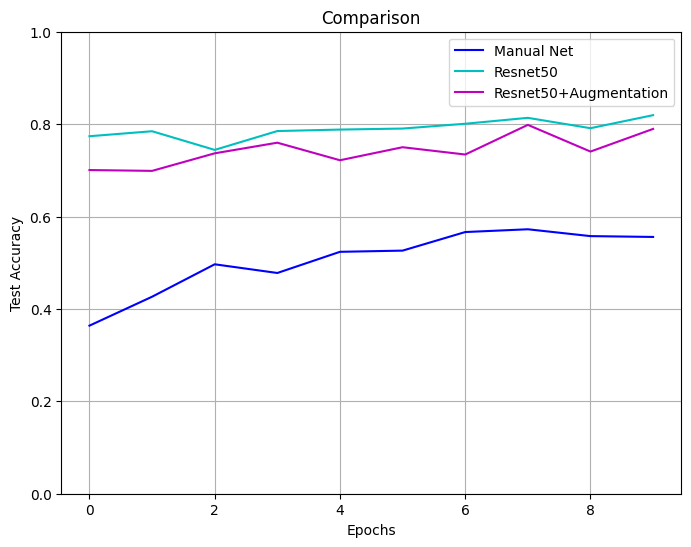

In [41]:
plt.figure(figsize=(8,6))

plt.plot(range(len(manual_acc_copy)), manual_acc_copy, color='b', label='Manual Net')
plt.plot(range(len(resnet_acc_copy)), resnet_acc_copy, color='c', label='Resnet50')
plt.plot(range(len(resnet_aug_acc_copy)), resnet_aug_acc_copy, color='m', label='Resnet50+Augmentation')


plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.title("Comparison")

plt.ylim(0,1)
plt.legend()
plt.grid()

plt.show()